In [1]:
import numpy as np
import seaborn as sns
import os, sys
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import glob
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
sys.path.append('../') 
# from permittivities import eps_YAG
# import permittivities

In [2]:
# Update plotting parameters
params = {'legend.fontsize': 'x-large',         
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.sans-serif': "Arial",
          'font.family': "sans-serif",
          'figure.figsize': (6, 6),
         }
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update(params)

In [3]:
def read_single_file(data_file):    
    return np.load(data_file, allow_pickle = True)

In [4]:
folder_name = "../res/updated_YAG100um_figure4/"
data0 = read_single_file(folder_name +"rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius0.0nm_nG_51.npy") 

wl_vec = data0.item().get("wl_vec")
pol_vec = {"s", "p"}
theta_vec = data0.item().get("theta_vec")
theta_mat = data0.item().get("theta_mat")
phi_mat = data0.item().get("phi_mat")
rad_etch = data0.item().get("rad_etch")

In [5]:
def symmetrize(M, sizes):    
    ## For triangular sweep: fills map with symmetry (here C4v)
    # First, fill other half of array (which is empty) with pi/4 mirror symmetry
    M0 = M[:] #Makes a copy 
    for ii in range(np.shape(M)[1]):
        for jj in range(np.shape(M)[2]):
            if np.all(M0[:,ii,jj,:] == 0):
                # C_{4v} symmetry enforced here: pay attention to (x,y) permutation! 
                M0[:,ii,jj,0] = M0[:,jj,ii,1]
                M0[:,ii,jj,1] = M0[:,jj,ii,0]

    # Then concatenate copies of LDOS0
    new_sizes = list(sizes)
    new_sizes[1] = 2*sizes[1]
    new_sizes[2] = 2*sizes[2]
    new_sizes = tuple(new_sizes)
    M_sym = np.zeros(new_sizes)
    for ii in range(np.shape(M_sym)[1]):
        ii0 = int(np.abs(ii - np.shape(M)[1] + 0.5))
        for jj in range(np.shape(M_sym)[2]):
            jj0 = int(np.abs(jj - np.shape(M)[2] + 0.5))
            M_sym[:,ii,jj,:] = M0[:,ii0,jj0,:]             
    M_sym = np.delete(M_sym, new_sizes[1]//2, axis = 1) # removes 0 angle that is counted twice otherwise
    M_sym = np.delete(M_sym, new_sizes[2]//2, axis = 2)    
    return M_sym

In [6]:
def process_data_file(file_name):    
    data = read_single_file(folder_name + file_name)
    etch_rad = data.item().get("etch_rad")
    etch_depth = data.item().get("etch_depth")    
    args = data.item().get("args")
#     data_mat = data.item().get("data_mat") 
    data_mat = data.item().get("data_mat") 
    R_mat = data.item().get("R_mat") 
    T_mat = data.item().get("T_mat") 
#     data_mat = np.squeeze(data_mat[:,:,:,:,0,0])
    data_matsym = symmetrize(data_mat, np.shape(data_mat))
    R_matsym = symmetrize(R_mat, np.shape(R_mat))    
    T_matsym = symmetrize(T_mat, np.shape(T_mat))        
    
    # Average over angle and plot as a function of meas_depth
    num_angles = len(np.where(data_matsym[100, :, :, 0] != 0.)[0])
    data_matavg = np.squeeze(np.sum(np.sum(data_matsym,1),1))/num_angles
    R_matavg = np.squeeze(np.sum(np.sum(R_matsym,1),1))/num_angles    
    T_matavg = np.squeeze(np.sum(np.sum(T_matsym,1),1))/num_angles        
    return data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg

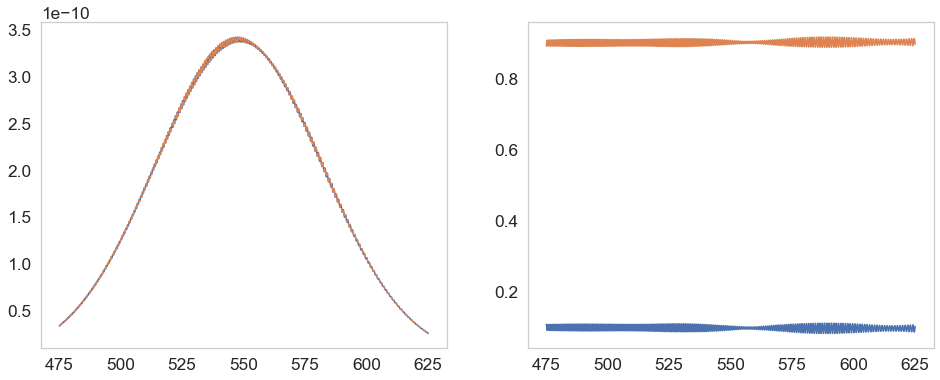

Scintillation yield REF = 2.8150177441198886e-08


In [7]:
# Reference (unpatterned)
# epsi = np.imag(eps_YAG(wl_vec, doping = "Ce"))
width = 0.080
sig = width / 2.355
wl0 = 0.550
epsi = 5e-5 * np.exp(-np.divide(np.square(wl_vec-wl0),2.*sig**2.))
# epsi =1.

data_matsym_ref, data_matavg_ref, R_matsym_ref, R_matavg_ref, T_matsym_ref, T_matavg_ref = process_data_file("rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius0.0nm_nG_51.npy")
fig, axs = plt.subplots(1, 2, figsize=(16,6 ))
axs[0].plot(wl_vec*1e3, data_matavg_ref[:,0]*epsi, label = "X Pol")
axs[0].plot(wl_vec*1e3, data_matavg_ref[:,1]*epsi, '--', label = "Y Pol")

axs[1].plot(wl_vec*1e3, R_matavg_ref[:,0])
axs[1].plot(wl_vec*1e3, T_matavg_ref[:,0])
scint_yield_ref = np.trapz(data_matavg_ref[:,0]*epsi, x = wl_vec*1e3)
plt.show()
print("Scintillation yield {0} = {1}".format("REF", scint_yield_ref))

In [8]:
file_list = []
for file in glob.glob(folder_name + "/*.npy"):
# for file in glob.glob(folder_name + "/*.npy"):
    file_name = re.split(folder_name, file)[1]
    file_list.append(file_name)

Scintillation yield rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius125.0nm_nG_51.npy = 7.044080374845226e-08 (enhancement = 2.502321837778521)
Scintillation yield rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius0.0nm_nG_51.npy = 2.8150177441198886e-08 (enhancement = 1.0)


<Figure size 432x432 with 0 Axes>

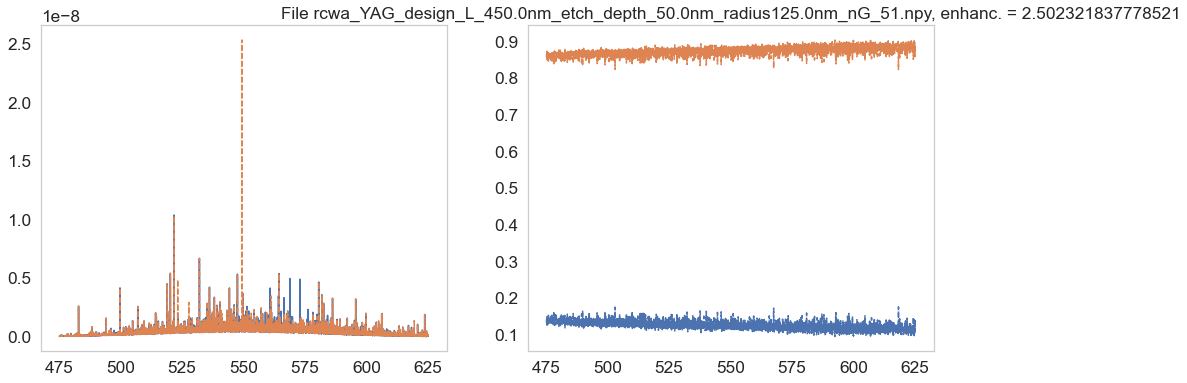

<Figure size 432x432 with 0 Axes>

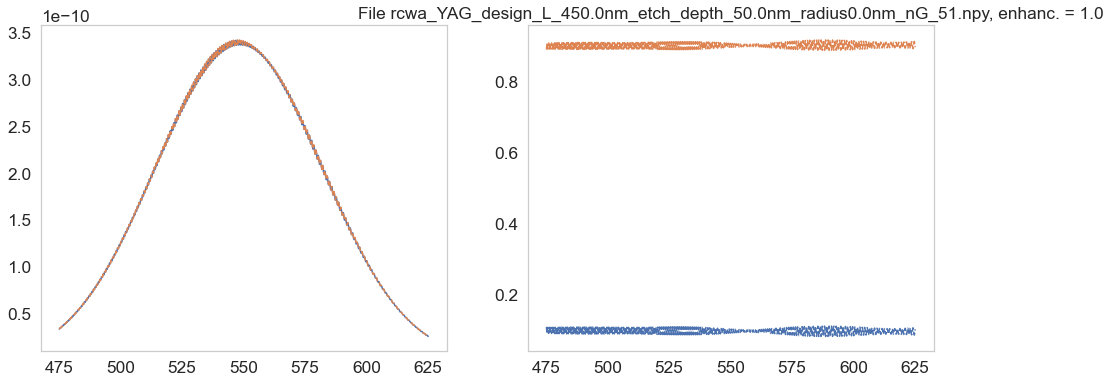

In [9]:
scint_yield_enhanc_list = []
L_list = [] 
for file in file_list:
    data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg = process_data_file(file)
    scint_yield = np.trapz(data_matavg[:,0]*epsi, x = wl_vec*1e3)
    scint_yield_enhanc_list.append(scint_yield/scint_yield_ref)
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(16,6 ))
    wl_range = np.arange(0,len(wl_vec))
    axs[0].plot(wl_vec[wl_range]*1e3, data_matavg[wl_range,0]*epsi, label = "X Pol")
    axs[0].plot(wl_vec[wl_range]*1e3, data_matavg[wl_range,1]*epsi, '--', label = "Y Pol")
    axs[1].plot(wl_vec[wl_range]*1e3, R_matavg[wl_range,0], '--', label = "R")
    axs[1].plot(wl_vec[wl_range]*1e3, T_matavg[wl_range,0], '--', label = "T")
    plt.title("File {0}, enhanc. = {1}".format(file, scint_yield/scint_yield_ref))
    print("Scintillation yield {0} = {1} (enhancement = {2})".format(file, scint_yield, scint_yield/scint_yield_ref))
    L_list.append(float(re.findall("L_(\d+)", file)[0]))
    # plt.show()

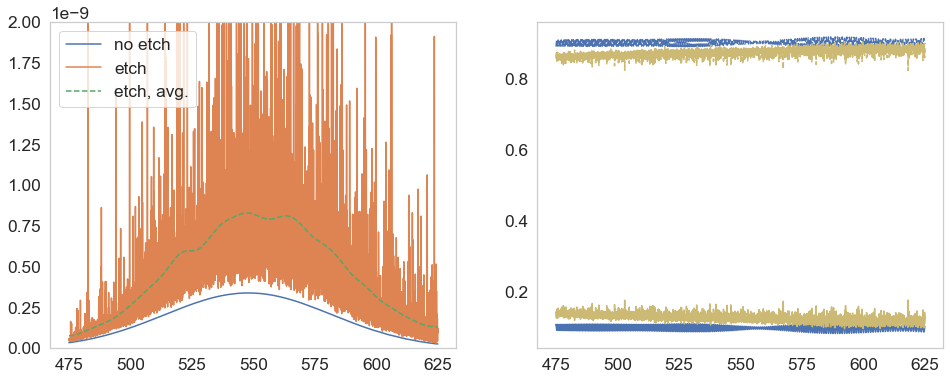

In [10]:
from scipy.ndimage import gaussian_filter1d
fig, axs = plt.subplots(1, 2, figsize=(16,6 ))
file = "rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius0.0nm_nG_51.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg = process_data_file(file)
axs[0].plot(wl_vec[wl_range]*1e3, gaussian_filter1d(data_matavg[wl_range,0]*epsi, 10), label = 'no etch')
axs[1].plot(wl_vec[wl_range]*1e3, R_matavg[wl_range,0], color = 'b')
axs[1].plot(wl_vec[wl_range]*1e3, T_matavg[wl_range,0], '--', color = 'b')

file = "rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius125.0nm_nG_51.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg = process_data_file(file)
axs[0].plot(wl_vec[wl_range]*1e3, data_matavg[wl_range,0]*epsi, label = 'etch')
axs[0].plot(wl_vec[wl_range]*1e3, gaussian_filter1d(data_matavg[wl_range,0]*epsi,100), '--', label = 'etch, avg.')
axs[1].plot(wl_vec[wl_range]*1e3, R_matavg[wl_range,0], color = 'y')
axs[1].plot(wl_vec[wl_range]*1e3, T_matavg[wl_range,0], '--', color = 'y')
# axs[1].set_xlim([540, 545])
axs[0].set_ylim([0, 2e-9])

axs[0].legend()
plt.show()

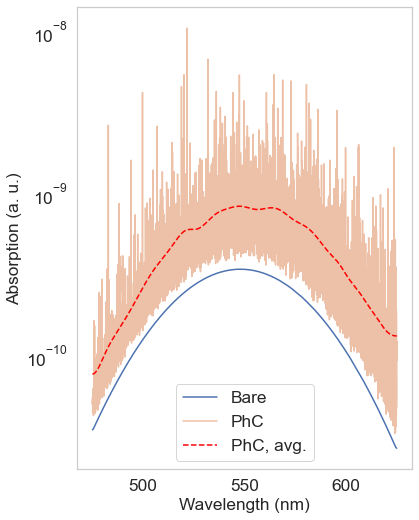

In [11]:
fig = plt.figure(figsize = (6,8.5))
file = "rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius0.0nm_nG_51.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg = process_data_file(file)
plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(data_matavg[wl_range,0]*epsi, 10), label = 'Bare')

file = "rcwa_YAG_design_L_450.0nm_etch_depth_50.0nm_radius125.0nm_nG_51.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg = process_data_file(file)
plt.semilogy(wl_vec[wl_range]*1e3, data_matavg[wl_range,0]*epsi, label = 'PhC', alpha = 0.5)
plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(data_matavg[wl_range,0]*epsi,100), '--', label = 'PhC, avg.', color = 'red')
# axs[1].set_xlim([540, 545])
# plt.ylim([0, 2e-9])
plt.ylabel("Absorption (a. u.)")
plt.xlabel("Wavelength (nm)")

plt.legend()
plt.savefig("sim_fig4.svg")